In [1]:
from cgisim_sims import cgisim_sims
import matplotlib.pylab as plt
import proper
import roman_phasec_proper
import numpy as np
import astropy.io.fits as pyfits
from scipy.ndimage import rotate

### For CGISim to be able to handle spectra, the files need to be .dat files, with a format that looks like: 
<div>
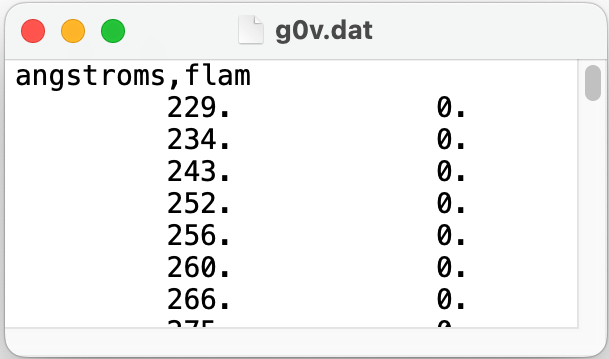
</div>

The spectrum units can be one of four types:

|   Name   |   Units               | 
|:--------:|:---------------------:|
|  FLAM    |  erg / s / cm^2 / A   | 
|    JY    |     Jansky            | 
|   FNU    | erg / s / cm^2 / Hz   |  
| PHOTLAM  | photon / s / cm^2 / A |

but all flux will be converted to units of `PHOTLAM` in the script. Wavelength must be given in Angstroms.

If your spectral file is given in different units, they will need to be converted before they can be used in CGISim.

In [2]:
# Wavelength conversion factors
um_to_A = 1e4 # convert um to Angstroms
nm_to_A = 10    # convert nm to Angstroms
cm_to_A = 1e8

Load in planet spectrum:

In [40]:
filepath = "/Users/sammyh/Documents/Projects/Planet Modeling/Cahoy_et_al_2010_Albedo_Spectra/albedo_spectra/"
planet_file = "Jupiter_1x_2AU_0deg.dat"
wavelength, alb_spec = np.loadtxt(filepath + planet_file, unpack=True)
r = 2 # [AU] distance from star
# This spectrum has wavelength in um and the spectrum is albedo spectrum

# Convert the planet wavelengths to Angstroms:
wavelength = np.array([x*um_to_A for x in wavelength])

Load in solar spectrum:

In [41]:
solar_filepath = "/Users/sammyh/Documents/Projects/Planet Modeling/Cahoy_et_al_2010_Albedo_Spectra/SOLARSPECTRUM.DAT"
solar_wavelength, solar_spec = np.loadtxt(solar_filepath, unpack=True)
# Solar spectrum has wavelength in Angstroms and spectrum has units of cgs/Angstrom

In [42]:
# Adjust stellar spectrum for distance of planet from star
solar_spec = solar_spec / r**2
# Interpolate solar spectrum on planet wavelength grid
solar_flux = np.interp(wavelength, solar_wavelength, solar_spec)

**Convert planet spectrum from albedo to flux space:**

In [43]:
planet_flux = alb_spec * solar_flux # A_g(lambda) * F_star(lambda) = F_planet(lambda)

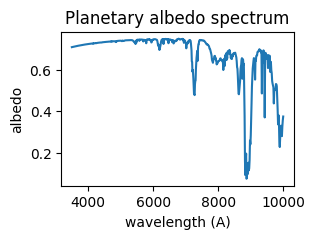

In [44]:
plt.figure(figsize=(3,2))
plt.plot(wavelength, alb_spec)
plt.xlabel('wavelength (A)')
plt.ylabel('albedo')
plt.title('Planetary albedo spectrum')
plt.show()

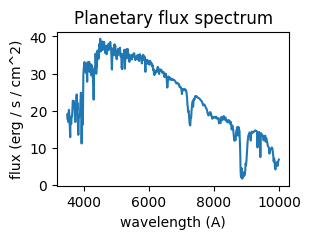

In [45]:
plt.figure(figsize=(3,2))
plt.plot(wavelength, planet_flux)
plt.ylabel('flux (erg / s / cm^2)')
plt.xlabel('wavelength (A)')
plt.title('Planetary flux spectrum')
plt.show()

### Write converted planet spectrum to file:
- Header should contain only units of spectrum
- First column: wavelength
- Second column: spectrum

In [46]:
spec_units = 'flam'
wave_units = 'angstroms'
spec_data = np.column_stack((wavelength, planet_flux))

filename = planet_file[:-4] + "_Angstroms_FLAM.dat"
np.savetxt('/Users/sammyh/Desktop/'+filename, spec_data, fmt='%.4f', 
          header='angstroms,flam', delimiter='\t', comments='')

## To convert the planet-star flux ratio to a magnitude:
$m_{planet} = m_{star} - 2.5 log_{10}( \frac{F_{planet}}{F_{star}})$

$\frac{F_p}{F_s} = A_g(\lambda) * \Phi(\lambda) * (\frac{R_p}{d})^2$

In [47]:
m_star = 5.0 
phi_lambda = 1.0 # phase function = 1.0 at phase = 0Â°
R_p = 69911      # Radius of Jupiter in km
d = r * 1.496e8  # distance from host star in km

m_planet = m_star - 2.5 * np.log10(alb_spec * (R_p / d)**2)

In [48]:
# Get index of center of wavelength band to grab planet magnitude
center_id = np.where((wavelength <= 5755) & (wavelength >= 5745))[0]
planet_mag = m_planet[center_id]
planet_mag

array([23.47904297])